# Load and visualize precomputed samples

In [1]:
import logging
import os

import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from csb.io import load

import geosss as gs
from geosss.spherical_curve import SlerpCurve, brownian_curve

mpl.rcParams["mathtext.fontset"] = "cm"

In [2]:
# `tester` instances samplers
methods = ("sss-reject", "sss-shrink", "rwmh", "hmc")
algos = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}

kappa = 800.0  # concentration parameter
n_samples = int(1e6)  # number of samples per sampler (default: 1000)
burnin = int(0.1 * n_samples)  # burn-in
n_dim = 5  # dimensionality (default: 10)
savefig = False  # save the plots
run_index = 0

# directory to save results
loaddirs = {
    "vary_kappa_ndim10": f"results/curve_10d_vary_kappa_nruns_10/curve_10d_kappa_{float(kappa)}",
    "vary_kappa_ndim5": f"results/curve_5d_vary_kappa_nruns_10/curve_5d_kappa_{float(kappa)}",
    "vary_ndim_kappa_500": f"results/curve_kappa_500.0_vary_ndim_nruns_10/curve_{n_dim}d_kappa_{float(kappa)}",
    "vary_ndim_kappa_800": f"results/curve_kappa_800.0_vary_ndim_nruns_10/curve_{n_dim}d_kappa_{float(kappa)}",
}

# path where the samples are saved
loaddir = loaddirs["vary_kappa_ndim5"]
loadpath_samples = (
    f"{loaddir}/curve_samples_{n_dim}d_kappa_{float(kappa)}_run{run_index}.pkl"
)
try:
    samples_all = load(loadpath_samples)
    print(f"Samples loaded from {loadpath_samples}.")
    print(f"\n-----INFO------\nkappa: {kappa}\nn_dim: {n_dim}\n---------------")
except FileNotFoundError as e:
    print(e)

Samples loaded from results/curve_5d_vary_kappa_nruns_10/curve_5d_kappa_800.0/curve_samples_5d_kappa_800.0_run0.pkl.

-----INFO------
kappa: 800.0
n_dim: 5
---------------


In [3]:
from geosss.distributions import CurvedVonMisesFisher

# optional controls
is_brownian_curve = True  # brownian curve or curve with fixed knots
reprod_switch = True  # seeds samplers for reproducibility
rerun_if_samples_exists = False  # rerun even if samples file exists

# creating a target as a curve on the sphere
if not is_brownian_curve:
    knots = np.array(
        [
            [-0.25882694, 0.95006168, 0.17433133],
            [0.14557335, 0.61236727, 0.77705516],
            [-0.7973001, -0.25170369, 0.54859622],
            [0.03172733, -0.71944851, 0.69382074],
            [0.56217797, -0.29453368, 0.77279094],
            [0.80883044, 0.1316755, 0.57310983],
            [0.98981463, 0.03039439, -0.13907979],
            [0.81592815, 0.04723609, -0.57622045],
            [0.36888235, 0.400026, -0.83899047],
            [-0.6770828, 0.05213374, -0.73405787],
        ]
    )

    # Pad to match dimensionality if needed
    if n_dim > knots.shape[1]:
        knots = np.pad(knots, ((0, 0), (n_dim - knots.shape[1], 0)))

else:
    # generates a smooth curve on the sphere with brownian motion
    knots = brownian_curve(
        n_points=10,
        dimension=n_dim,
        step_size=0.5,  # larger step size will result in more spread out points
        seed=4562,
    )

print(f"Target curve: {knots}")
# defining the curve on the sphere
curve = SlerpCurve(knots)

# defining this curve as vMF distribution
pdf = CurvedVonMisesFisher(curve, kappa)

Target curve: [[ 0.02636747 -0.14072706  0.93626057 -0.23920124 -0.21377456]
 [ 0.07096614 -0.25028686  0.76417377 -0.58810245 -0.04994251]
 [ 0.21552926  0.03900849  0.77144079 -0.59463745  0.05754035]
 [ 0.26334113 -0.74994064  0.44831589 -0.36188446  0.19050718]
 [ 0.13634453 -0.98266368  0.04152965 -0.00313512  0.11852306]
 [-0.14729166 -0.93792811  0.01092164  0.27199955 -0.15650234]
 [-0.39505787 -0.80283626  0.24512379  0.21200575 -0.30716627]
 [-0.65623213 -0.63599866  0.19619555  0.16593374 -0.31438573]
 [-0.67578922 -0.07993955 -0.3431324   0.54337255 -0.35202985]
 [-0.76440935 -0.14954678 -0.5783955  -0.0745347  -0.23068884]]


### Plot scatter natrix with `corner.corner`

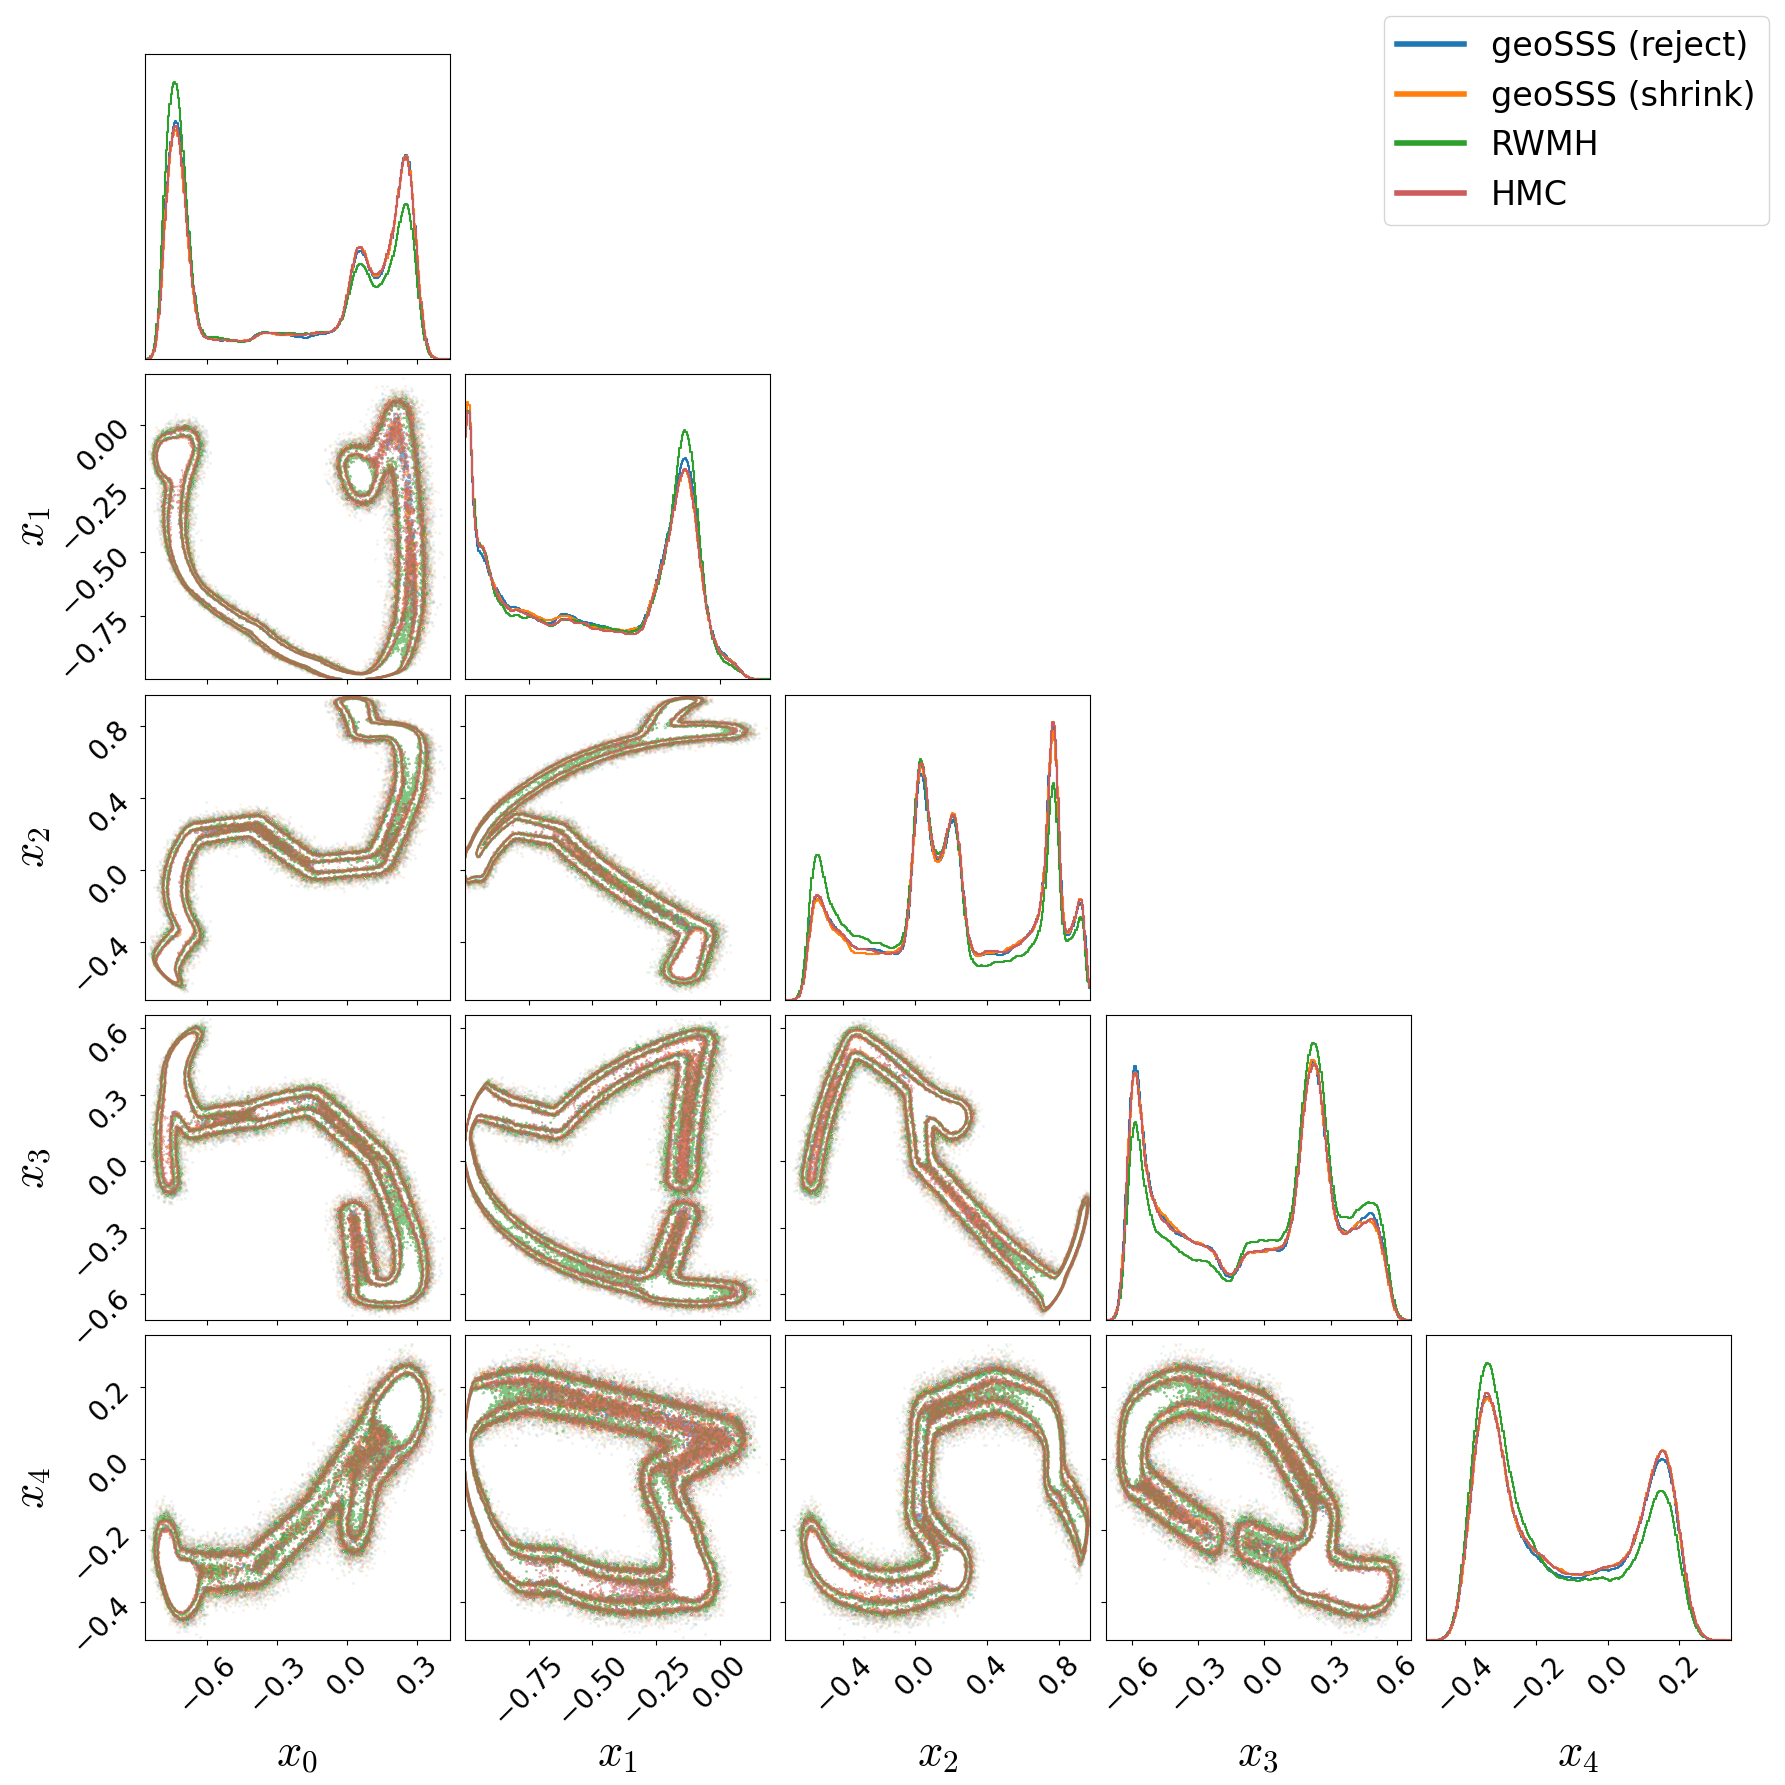

In [6]:
def scatter_matrix(n_dim, samples, methods, algos, loadpath, filename, savefig=False):
    """
    Plotting scatter matrix with the corner library and adjusted label sizes
    """
    # Define font sizes
    label_size = 32  # Size for axis labels
    tick_size = 20  # Size for tick labels
    legend_size = 24  # Size for legend

    # create dir to save scatter matrices
    labels = [rf"$x_{i}$" for i in range(n_dim)]

    # Set default font sizes for matplotlib
    plt.rcParams.update(
        {
            "font.size": tick_size,
            "axes.labelsize": label_size,
            "axes.titlesize": label_size,
            "xtick.labelsize": tick_size,
            "ytick.labelsize": tick_size,
        }
    )

    # Create custom labels for each dataset
    colors = ["tab:blue", "tab:orange", "tab:green", "indianred"]

    figure = plt.figure(figsize=(18, 18))

    for method, color in zip(methods, colors):

        # samples for every method (draws, dimensions)
        samples_per_method = samples[method][: int(1e6)]

        # First corner plot for contours and 1D histograms using all samples
        figure = corner.corner(
            samples_per_method,
            bins=250,
            color=color,
            labels=labels,
            fig=figure,
            plot_density=False,
            plot_contours=True,  # shows the 2D histograms with contours
            contour_kwargs={"alpha": 0.6},
            plot_datapoints=False,
            levels=[0.68, 0.95],
            labelsize=label_size,
            label_kwargs={"fontsize": label_size, "labelpad": 10},
            tick_labels_size=tick_size,
            hist_kwargs={"alpha": 1.0},  # 1D histogram
            smooth1d=2,  # smoothens the 1D histogram
        )

        # Second corner plot for showing fewer scatter points
        figure = corner.corner(
            samples_per_method[::20],
            bins=50,
            color=color,
            plot_density=False,
            plot_contours=False,
            fig=figure,
            plot_datapoints=True,  # only shows the scatter points
            data_kwargs={"alpha": 0.1},
            labels=labels,
            labelsize=label_size,
            label_kwargs={"fontsize": label_size, "labelpad": 10},
            tick_labels_size=tick_size,
            hist_kwargs={"alpha": 0.0},  # 1D histogram disabled
        )

    # Create custom legend with the figure instance
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    figure.legend(
        legend_handles,
        [algos[method] for method in methods],
        loc="upper right",
        fontsize=legend_size,
    )

    # Adjust tick label sizes for all axes
    axes = np.array(figure.axes).reshape((n_dim, n_dim))
    for ax in axes.flat:
        if ax is not None:
            ax.tick_params(labelsize=tick_size)

    # save corner plot
    if savefig:
        savedir = f"{loadpath}/corner_plots"
        os.makedirs(savedir, exist_ok=True)
        logging.info(f"Saving corner plot to {savedir}/{filename}.pdf")
        figure.savefig(f"{savedir}/{filename}.pdf", bbox_inches="tight", dpi=150)


# corner plot (scatter matrix)
scatter_matrix(
    n_dim,
    samples_all,
    methods,
    algos,
    loaddir,
    # f"curve_corner_{n_dim}d_kappa{int(kappa)}_run{run_index}",
    f"curve_corner_{n_dim}d_kappa{int(kappa)}",
    savefig=True,
)

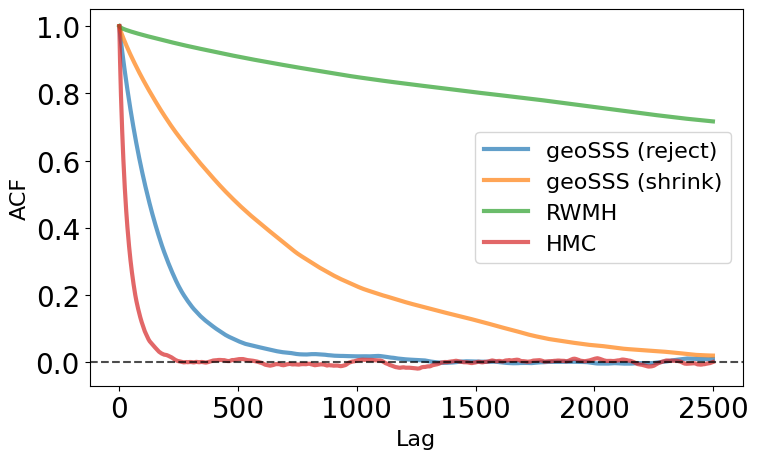

In [55]:
savefig_acf = False
fs = 16
fig, ax = plt.subplots(figsize=(8, 5), sharex=True, sharey=True)
for method in methods:
    ac = gs.acf(samples_all[method][:, 0], 2500)
    ax.plot(ac, alpha=0.7, lw=3, label=algos[method])
ax.axhline(0.0, ls="--", color="k", alpha=0.7)
ax.set_xlabel(r"Lag", fontsize=fs)
ax.set_ylabel("ACF", fontsize=fs)
ax.legend(fontsize=fs)
fig.tight_layout()
if savefig_acf:
    savedir_acf = f"{loaddir}/acf_plots"
    os.makedirs(savedir_acf, exist_ok=True)
    fig.savefig(
        f"{savedir_acf}/curve_acf_kappa{int(kappa)}_run{run_index}.pdf",
        bbox_inches="tight",
        transparent=True,
        dpi=150,
    )

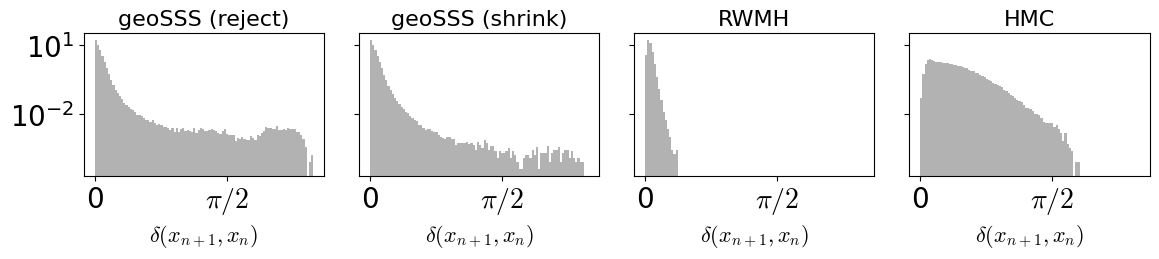

In [56]:
savefig_dist = False
fs = 16
# geodesic distance between successive samples
fig, axes = plt.subplots(
    1, len(methods), figsize=(len(methods) * 3, 3), sharex=True, sharey=True
)
bins = 100
for ax, method in zip(axes, methods):
    ax.set_title(algos[method], fontsize=fs)
    # distance between successive samples
    x = samples_all[method]
    geo_dist = gs.sphere.distance(x[:-1], x[1:])
    logging.info(
        "average great circle distance of successive samples: "
        f"{np.mean(geo_dist):.2f} ({method})"
    )
    bins = ax.hist(
        geo_dist,
        bins=bins,
        density=True,
        alpha=0.3,
        color="k",
        histtype="stepfilled",
    )[1]
    ax.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=fs)
    ax.set_xticks(np.linspace(0.0, np.pi, 3))
    ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"])
    ax.semilogy()
fig.tight_layout()
if savefig_dist:
    savedir_dist = f"{loaddir}/dist_plots"
    os.makedirs(savedir_dist, exist_ok=True)
    fig.savefig(
        f"{savedir_dist}/curve_dist_kappa{int(kappa)}_run{run_index}.pdf",
        bbox_inches="tight",
        transparent=True,
        dpi=150,
    )

### Combine ACF and distance plot

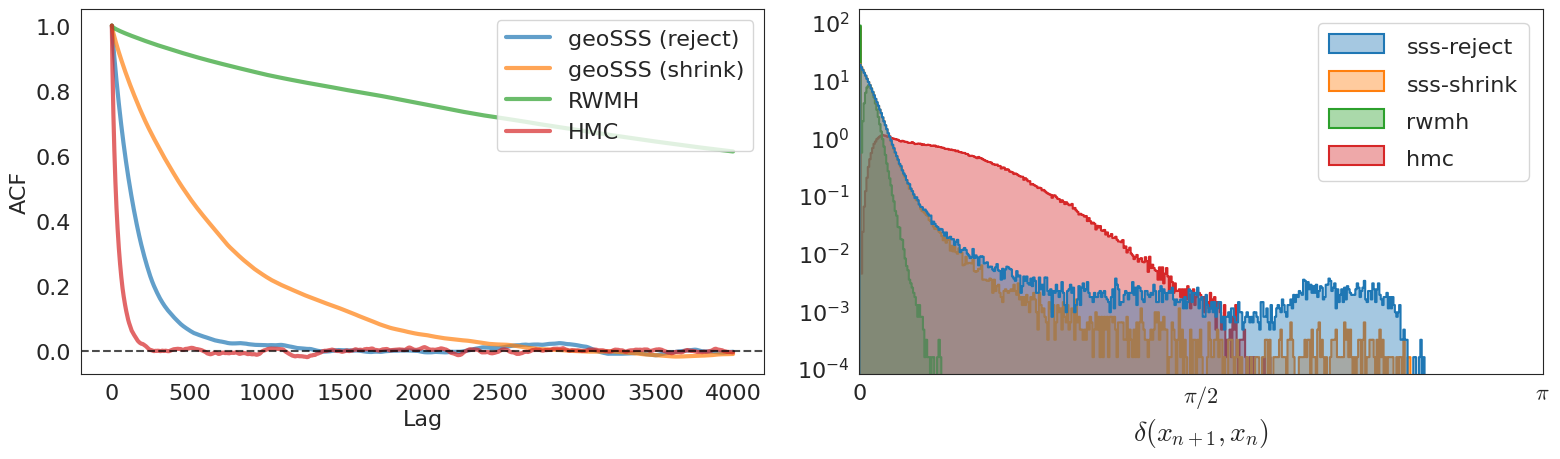

In [105]:
import pandas as pd
import seaborn as sns
import warnings

# Suppress FutureWarnings (optional)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define your methods and corresponding colors
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
method_color_dict = dict(zip(methods, colors))


# Font size for labels and titles
fs = 16

# Create the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

### First Subplot: Autocorrelation Function ###
ax1 = axes[0]

for method, color in zip(methods, colors):
    ac = gs.acf(samples_all[method][:, 0], 4000)
    ax1.plot(ac, alpha=0.7, lw=3, label=algos[method], color=color)

ax1.axhline(0.0, ls="--", color="k", alpha=0.7)
ax1.set_xlabel(r"Lag", fontsize=fs)
ax1.set_ylabel("ACF", fontsize=fs)
ax1.tick_params(axis="both", which="major", labelsize=fs)
ax1.legend(fontsize=fs, loc="upper right")

### Second Subplot: Geodesic Distance Histogram ###
ax2 = axes[1]

# Prepare the data for the histogram
geo_dist_list = []
for method in methods:
    x = samples_all[method]
    # Compute geodesic distances between successive samples
    geo_dist = gs.sphere.distance(x[:-1], x[1:])
    # Check for Inf or NaN values
    if not np.all(np.isfinite(geo_dist)):
        logging.warning(f"Infinite or NaN values found in geo_dist for method {method}")
        # Remove or handle these values
        geo_dist = geo_dist[np.isfinite(geo_dist)]
    logging.info(
        "average great circle distance of successive samples: "
        f"{np.mean(geo_dist):.2f} ({method})"
    )
    # Create a DataFrame for the current method
    df_method = pd.DataFrame({"geo_dist": geo_dist, "method": method})
    geo_dist_list.append(df_method)

# Combine all DataFrames into one
df_geo_dist = pd.concat(geo_dist_list, ignore_index=True)

# Set the style
sns.set_style("white")  # Remove the background grid

# Create the histogram plot using Seaborn
sns.histplot(
    data=df_geo_dist,
    x="geo_dist",
    hue="method",
    bins=400,
    stat="density",
    element="step",  # Use 'bars' for filled histograms
    fill=True,  # Set to True for filled histograms
    common_norm=False,  # Normalize each histogram independently
    linewidth=1.5,  # Adjust line width for better visibility
    alpha=0.4,
    ax=ax2,
    palette=method_color_dict,
    legend=True,  # Ensure legend is enabled
)

# Customize the x-axis labels and ticks
ax2.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=20)
ax2.set_xticks([0, np.pi / 2, np.pi])
ax2.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"], fontsize=20)
ax2.tick_params(axis="both", which="major", labelsize=fs)

# Set y-scale to logarithmic
ax2.set_yscale("log")
ax2.set_ylabel(None)  # Remove the y-axis label
ax2.set_xlim(0, np.pi)

# Customize the legend
leg = ax2.get_legend()
if leg is not None:
    leg.set_title(None)  # Remove the legend title
    for t in leg.texts:
        t.set_fontsize(fs)
    # Optionally, adjust the legend location
    leg.set_bbox_to_anchor((1, 1))
else:
    logging.warning("Legend not found in ax2.")


# Adjust layout
fig.tight_layout()

savedir_acf_dist = f"{loaddir}/dist_acf_plots"
os.makedirs(savedir_acf_dist, exist_ok=True)
fig.savefig(
    f"{savedir_acf_dist}/curve_acf_distplot_run{run_index}.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=150,
)

## Brownian motion for a smooth curve on the sphere

The **Brownian motion on a sphere** can be described as a random walk where each new point is generated by taking a small random step from the previous point, followed by normalization to ensure the point remains on the surface of the sphere. Here's a step-by-step breakdown of the implementation with equations:

The process can be described by the following steps:

1. **Initial Point**: 
   $$
   \mathbf{x}_0 = \frac{\mathbf{v}}{\|\mathbf{v}\|}
   \quad \text{where} \quad \mathbf{v} \sim \mathcal{N}(0, 1)^{d+1}
   $$
2. **Iteration**:
   $$
   \mathbf{\Delta x}_i \sim \mathcal{N}(0, \sigma^2)^{d+1}
   $$
   $$
   \mathbf{x}_{i+1} = \frac{\mathbf{x}_i + \mathbf{\Delta x}_i}{\|\mathbf{x}_i + \mathbf{\Delta x}_i\|}
   $$
   This step is repeated for $n $ steps to generate the sequence of points $\mathbf{x}_0, \mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n $.

### Parameters:
- $\sigma $ (the step size) controls the magnitude of random motion between successive points.
- The dimension $d $ controls the dimensionality of the sphere (for the 9-sphere, $d = 9 $, so the points are in $\mathbb{R}^{10} $).

### Result:
This approach generates a **smooth random path** on the surface of the sphere, where each new point is a small perturbation of the previous one, and the points remain on the unit sphere due to normalization after each step.

This method ensures that the points are smooth in the sense that they follow a continuous random walk on the surface of the sphere. The smoothness depends on the step size: a smaller step size results in more closely spaced points, and a larger step size gives more spread-out points.

In [8]:
def brownian_curve_on_sphere(n_points=100, dimension=6, step_size=0.05, seed=1234):
    """
    Generate smooth points on a unit d-sphere using Brownian motion.

    Parameters:
    n_points: number of points to generate
    dimension: dimension of the sphere
    step_size: step size for the Brownian motion, increasing it will make the points jump more
    seed: random seed
    """
    rng = np.random.default_rng(seed)

    # Initialize the first point on the 9-sphere
    points = np.zeros((n_points, dimension))
    points[0] = rng.normal(size=dimension)
    points[0] /= np.linalg.norm(points[0])  # Normalize to the unit sphere

    # Generate subsequent points via Brownian motion (small random steps)
    for i in range(1, n_points):
        step = rng.normal(size=dimension) * step_size
        new_point = points[i - 1] + step

        # Project back to the unit sphere
        points[i] = new_point / np.linalg.norm(new_point)

    return points


# Generate points on the 9-sphere via Brownian motion
n_dim = 20
brownian_points = brownian_curve_on_sphere(
    n_points=10,
    dimension=n_dim,
    step_size=0.8,
    seed=4562,
)

Max spherical distance between consecutive points: 1.6056797704338952


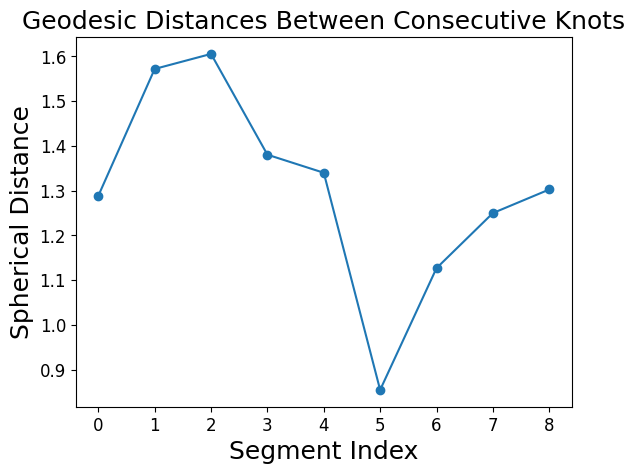

In [9]:
curve = SlerpCurve(brownian_points)

knots = curve.knots
distances = [gs.sphere.distance(knots[i], knots[i + 1]) for i in range(len(knots) - 1)]
print("Max spherical distance between consecutive points:", np.max(distances))

# Plot distances between consecutive knots
plt.plot(distances, marker="o")
plt.xlabel("Segment Index")
plt.ylabel("Spherical Distance")
plt.title("Geodesic Distances Between Consecutive Knots")
plt.show()

In [10]:
total_length = np.sum(distances)
print(
    f"Total length of the curve on the unit sphere (less than {n_dim * np.pi:.2f}?): {total_length:.2f}"
)

Total length of the curve on the unit sphere (less than 62.83?): 11.72


### PCA for reducing dimensionality from d-sphere to 2-sphere

Implementation for quick visualization of point continuity.

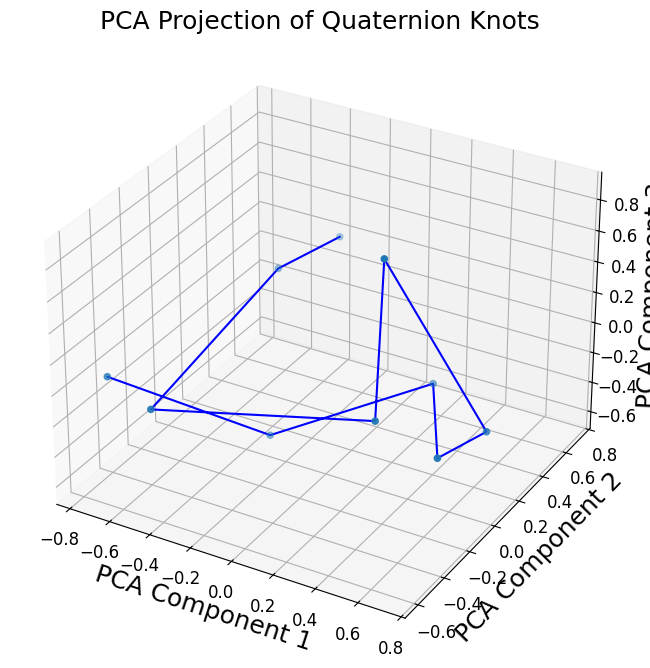

In [11]:
from sklearn.decomposition import PCA

# Apply PCA to reduce from 6D/ND to 3D
pca = PCA(n_components=3)
projected_knots = pca.fit_transform(curve.knots)

# Visualize the projected knots
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    projected_knots[:, 0], projected_knots[:, 1], projected_knots[:, 2], marker="o"
)
ax.plot(
    projected_knots[:, 0], projected_knots[:, 1], projected_knots[:, 2], color="blue"
)

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.title("PCA Projection of Quaternion Knots")
plt.show()